In [120]:

import anytree.search
import matplotlib.pyplot as plt
import pandas as pd
from anytree.importer import JsonImporter
import os
import json
import datetime
import numpy as np

In [11]:
# survey.csv
# depth.csv
# breadth.csv

In [91]:
right_wing_seeds = []
left_wing_seeds = []

channels_df = pd.read_csv('C:\\Users\\mikad\\PycharmProjects\\Comp_396_YouTube_Radicalization\\channel_review.csv')

with open('C:\\Users\\mikad\\PycharmProjects\\Comp_396_YouTube_Radicalization\\seeds\\seeds_right') as outfile:
    lines = outfile.read().splitlines()
    for i in lines:
        right_wing_seeds.append(i)

with open('C:\\Users\\mikad\\PycharmProjects\\Comp_396_YouTube_Radicalization\\seeds\\seeds_left') as outfile:
    lines = outfile.read().splitlines()
    for i in lines:
        left_wing_seeds.append(i)

In [92]:
#get dictionary of dictionairies
path_videos = 'D:\\Data Science\\YouTube Content Silos\\Videos'
video_info = {}
json_files = os.listdir(path_videos)

for file in json_files:
    with open(path_videos+ '/' +file, 'r') as outfile:
        data = json.load(outfile)
        video_info.update(data)

print(len(video_info.keys()))

17126


In [93]:
tags_right = ['AntiSJW', 'Conspiracy', 'PartisanRight', 'ReligiousConservative', 'WhiteIdentitarian', 'Libertarian', 'MRA', 'Total']
tags_left = ['SocialJustice', 'Socialist', 'PartisanLeft', 'AntiWhiteness', 'LGBT']

all_tags  = tags_right + tags_left

In [137]:
# paths to everything
path_survey_trees = "D:\\Data Science\\YouTube Content Silos\\Survey\\tree"
path_survey_homepage = "D:\\Data Science\\YouTube Content Silos\\Survey\\homepage"

survey_trees = os.listdir(path_survey_trees)
survey_homepages = os.listdir(path_survey_homepage)

path_depth_trees = "D:\\Data Science\\YouTube Content Silos\\Depth\\tree"
path_depth_homepage = "D:\\Data Science\\YouTube Content Silos\\Depth\\homepage"

depth_trees = os.listdir(path_depth_trees)
depth_homepages = os.listdir(path_depth_homepage)

path_breadth_trees = "D:\\Data Science\\YouTube Content Silos\\Breadth\\Scraping-21-02-22\\tree"
path_breadth_homepage = "D:\\Data Science\\YouTube Content Silos\\Breadth\\Scraping-21-02-22\\homepage"

breadth_trees = os.listdir(path_breadth_trees)
breadth_homepages = os.listdir(path_breadth_homepage)

In [95]:
# urls that are not in the dictionairy that we would like to visit
urls_to_visit = []

# 1. Get all the required video urls

To-do
* replace the breadth homepage urls
* homepage video urls
* recommended video urls
* tree node urls

In [96]:
importer = JsonImporter()

def text_to_date(date: str):
    date = date.replace(',', '')
    split_date = date.split(' ')
    return datetime.date(year=split_date[2], month=split_date[0], day=split_date[1])

def homepage_file_to_url(path_file:str):
    homepages = []
    with open(path_file, 'r') as outfile:
        lines = outfile.read().splitlines()
        lines = [i for i in lines if not(i == None)]
        lines = lines[0 : min(10, len(lines))]

        for i in lines:
            if not (i in video_info.keys()):
                homepages.append(i)
        outfile.close()
    return homepages

def tree_file_to_url_list(file_path: str):
    urls = []
    with open(file_path, 'r') as outfile:
        data = outfile.read()
        root = importer.import_(data)
        for t in anytree.LevelOrderIter(root):
            if not(t.id == 'dummy'):
                recommended_videos = t.top_10_recommended
                recommended_videos = [i for i in recommended_videos if not(i == None)]
                recommended_videos = recommended_videos[0:min(5, len(recommended_videos))]

                video_url = t.id
                urls.append(video_url)
                for reco_urls in recommended_videos:
                    urls.append(reco_urls)
    return urls

In [97]:
count = 0
for d_trees in depth_trees:
    urls = tree_file_to_url_list(path_depth_trees + '\\' + d_trees)
    for i in urls:
        count += 1
        if not(i in video_info.keys()):
            urls_to_visit.append(i)

for s_trees in survey_trees:
    urls = tree_file_to_url_list(path_survey_trees + '\\' + s_trees)
    for i in urls:
        count += 1
        if not(i in video_info.keys()):
            urls_to_visit.append(i)

In [98]:
# cycle through the homepages and get the urls
all_homepages = [survey_homepages, depth_homepages, breadth_homepages]
all_paths = [path_survey_homepage, path_depth_homepage, path_breadth_homepage]

for homepage_file, path in zip(all_homepages, all_paths):
    for file in homepage_file:
        file_path = path + '\\' + file
        with open(file_path, 'r') as outfile:
            urls = homepage_file_to_url(file_path)
            for i in urls:
                if not(i in video_info.keys()):
                    urls_to_visit.append(i)

In [99]:
urls_to_visit = list(set(urls_to_visit))
print(len(set(urls_to_visit)))

0


In [68]:
text_file_video_urls = open(f'{os.getcwd()}\\Videos to visit\\video urls.txt', 'w+')
for urls in urls_to_visit:
    text_file_video_urls.write(urls + '\n')
text_file_video_urls.close()

# 2. Perform data analysis

## a. Helper Scripts

In [100]:
#scripts common to all

"""
input : string
    - name of the YouTube video content creator
output : int
    - 1 -> content creator is right wing
    - (-1) -> content creator is left wing
    - 0 -> content creator is neither
"""
def content_creator_to_bias(content_creator):
    try:
        if (channels_df['CHANNEL_TITLE'].str.contains('^'+ content_creator +'$').sum() > 0):
            # now check what the type of the channels found were
            c = channels_df.loc[channels_df['CHANNEL_TITLE'].str.contains('^'+ content_creator +'$', case=False, na=False)]
            for tags in all_tags:
                if (c['REVIEWER_TAGS'].str.contains(tags).sum() > 0) or (c['TAGS'].str.contains(tags).sum() > 0):
                    if tags in tags_left:
                        return 'left rec'
                    elif tags in tags_right:
                        return 'right rec'
        return 'other rec'
    except Exception as e:
        print(content_creator)
        raise ValueError(f'Error raise: \n{e}')

"""
Description: given a url, it will return the content creator of the video
input : string
    - url of the video whose creator we want
output : String || None
    - content creator : string
    -  None if
        * url is None
        * url is empty
        * url is not known and needs to be scraped
"""
def url_to_content_creator(url:str):
    if url == None:
        return None

    url = url.strip('\n')

    if url in video_info.keys():
        return video_info[url]['content creator']
    elif url == '':
        return None
    else:
        urls_to_visit.append(url)
        return None

## b. Depth
### i. Recommended videos

In [171]:
importer = JsonImporter()

depth_left_ids = []
depth_right_ids = []

depth_right_trees = []
depth_left_trees = []

# figure out which files have right wing seed, which have left wing seed
for trees in depth_trees:
    id = (trees.split('_')[3]).replace('.txt', '')
    with open(path_depth_trees + '\\' + trees, 'r') as outfile:
        data = outfile.read()
        root = importer.import_(data)
        if root.id in right_wing_seeds:
            depth_right_ids.append(id)
        else:
            depth_left_ids.append(id)

In [101]:
depth_data = {
    'id': [],
    'position': [],
    'ply': [],
    'tree bias': [],
    'left rec': [],
    'right rec': [],
    'other rec': [],
    'total': [],
    'video bias': [],
}

#create the csv for the trees
tree_number = 0
for tree in depth_trees:
    tree_number += 1
    print(f'{tree_number}/{len(depth_trees)}', end='')
    id = (tree.split('_')[3]).replace('.txt', '')
    tree_bias = None
    if id in depth_left_ids:
        tree_bias = 'Left'
    elif id in depth_right_ids:
        tree_bias = 'Right'
    else:
        print(f'Problem')

    #'id', 'tree bias', 'left rec', 'right rec', 'other', 'total', 'video bias'
    with open(path_depth_trees + '\\' + tree, 'r') as outfile:
        data = outfile.read()
        root = importer.import_(data)
        position = 0
        corrupted = False
        for t in anytree.PreOrderIter(root):

            depth_data['id'].append(id)
            depth_data['tree bias'].append(tree_bias)
            depth_data['position'].append(position)
            count = {
                'left rec': 0,
                'right rec': 0,
                'other rec' : 0
            }
            # check that you only want top 5
            recommended_videos = t.top_10_recommended
            recommended_videos = [i for i in recommended_videos if not(i == None)]
            recommended_videos = recommended_videos[0:min(5, len(recommended_videos))]
            for rec in recommended_videos:
                if rec != None:
                    content_creator = url_to_content_creator(rec)
                    if content_creator != None:
                        bias =content_creator_to_bias(content_creator)
                        count[bias] += 1
                    else:
                        count['other'] += 1
                else:
                    corrupted = True
            for k, v in count.items():
                depth_data[k].append(v)
            depth_data['total'].append(5)
            video_bias = content_creator_to_bias(t.video['content creator'])
            depth_data['video bias'].append(video_bias)

            if position == 0:
                ply = 0
            else:
                pos_temp = position - 1
                pos_temp = np.mod(pos_temp, 6)
                ply = pos_temp + 1
            depth_data['ply'].append(ply)
            position += 1
        print(corrupted)
print(len(urls_to_visit))

1/79False
2/79False
3/79False
4/79False
5/79False
6/79

C:\Users\mikad\anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


False
7/79False
8/79False
9/79False
10/79False
11/79False
12/79False
13/79False
14/79False
15/79False
16/79False
17/79False
18/79False
19/79False
20/79False
21/79False
22/79False
23/79False
24/79False
25/79False
26/79False
27/79False
28/79False
29/79False
30/79False
31/79False
32/79False
33/79False
34/79False
35/79False
36/79False
37/79False
38/79False
39/79False
40/79False
41/79False
42/79False
43/79False
44/79False
45/79False
46/79False
47/79False
48/79False
49/79False
50/79False
51/79False
52/79False
53/79False
54/79False
55/79False
56/79False
57/79False
58/79False
59/79False
60/79False
61/79False
62/79False
63/79False
64/79False
65/79False
66/79False
67/79False
68/79False
69/79False
70/79False
71/79False
72/79False
73/79False
74/79False
75/79False
76/79False
77/79False
78/79False
79/79False
0


In [ ]:
for k, v in depth_data.items():
    print(k, len(v))

In [ ]:
depth_csv = pd.DataFrame.from_dict(depth_data)
depth_csv.head(10)

In [ ]:
right = depth_csv[depth_csv['tree bias'] == 'Right'][['position', 'ply', 'left rec', 'right rec', 'other', 'total']]
left = depth_csv[depth_csv['tree bias'] == 'Left'][['position', 'ply', 'left rec', 'right rec', 'other', 'total']]

avg_per_position_right = right.groupby('position').mean()
avg_per_position_left = left.groupby('position').mean()

In [ ]:
avg_per_position_left.plot(legend=True)

In [ ]:
avg_per_position_right.plot(legend=True)

### ii. Homepage videos depth

In [175]:
depth_homepage_data = {
    'id': [],
    'ply': [],
    'tree bias': [],
    'left rec' : [],
    'right rec': [],
    'other': [],
    'total' : []
}

homepage_number = 0
for homepage in depth_homepages:
    homepage_number += 1
    print(f'{homepage_number}/{len(depth_homepages)}')

    # check id
    id = (homepage.split('_')[4]).replace('.txt', '')

    # check ply
    ply = homepage.split('_')[1]
    tree_bias = None
    if id in depth_left_ids:
        tree_bias = 'Left'
    elif id in depth_right_ids:
        tree_bias = 'Right'
    else:
        print(f'Problem')

    with open(path_depth_homepage + '\\' + homepage, 'r') as outfile:
        # array of urls
        lines = outfile.read().splitlines()
        lines = [i for i in lines if (not(i == None) and not(i == ''))]
        lines = lines[0 : min(10, len(lines))]

        count = {
            'left rec': 0,
            'right rec': 0,
            'other': 0,
            'total': 0
        }
        none_count = 0
        for url in lines:
            content_creator = url_to_content_creator(url)
            if content_creator == None:
                none_count += 1
            else:
                bias = content_creator_to_bias(content_creator)
                count[bias] += 1
                count['total'] += 1
        for k, v in count.items():
            depth_homepage_data[k].append(v)
        depth_homepage_data['tree bias'].append(tree_bias)
        depth_homepage_data['ply'].append(ply)
        depth_homepage_data['id'].append(id)

    homepage_number += 1

1/560
Problem
3/560
5/560
7/560
9/560
11/560
13/560
15/560
17/560
19/560
21/560
23/560
25/560
27/560
29/560
31/560
33/560
35/560
37/560
39/560
41/560
43/560
45/560
47/560
49/560
51/560
53/560
55/560
57/560
59/560
61/560
63/560
65/560
67/560
69/560
71/560
73/560
75/560
77/560
79/560
81/560
83/560
85/560
87/560
89/560
91/560
93/560
95/560
97/560
99/560
101/560
103/560
105/560
107/560
109/560
111/560
113/560
115/560
117/560
119/560
121/560
123/560
125/560
127/560
129/560
131/560
133/560
135/560
137/560
139/560
141/560
143/560
145/560
147/560
149/560
151/560
153/560
155/560
157/560
159/560
161/560
Problem
163/560
165/560
167/560
169/560


C:\Users\mikad\anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


171/560
173/560
175/560
177/560
179/560
181/560
183/560
185/560
187/560
189/560
191/560
193/560
195/560
197/560
199/560
201/560
203/560
205/560
207/560
209/560
211/560
213/560
215/560
217/560
219/560
221/560
223/560
225/560
227/560
229/560
231/560
233/560
235/560
237/560
239/560
241/560
243/560
245/560
247/560
249/560
251/560
253/560
255/560
257/560
259/560
261/560
263/560
265/560
267/560
269/560
271/560
273/560
275/560
277/560
279/560
281/560
283/560
285/560
287/560
289/560
291/560
293/560
295/560
297/560
299/560
301/560
303/560
305/560
307/560
309/560
311/560
313/560
315/560
317/560
319/560
321/560
Problem
323/560
325/560
327/560
329/560
331/560
333/560
335/560
337/560
339/560
341/560
343/560
345/560
347/560
349/560
351/560
353/560
355/560
357/560
359/560
361/560
363/560
365/560
367/560
369/560
371/560
373/560
375/560
377/560
379/560
381/560
383/560
385/560
387/560
389/560
391/560
393/560
395/560
397/560
399/560
401/560
403/560
405/560
407/560
409/560
411/560
413/560
415/560
417/560


In [176]:
for k, v in depth_homepage_data.items():
    print(k, len(v))

id 560
ply 560
tree bias 560
left rec 560
right rec 560
other 560
total 560


In [177]:
depth_homepage_csv = pd.DataFrame.from_dict(depth_homepage_data)
depth_homepage_csv.head(10)

,id,ply,tree bias,left rec,right rec,other,total
0,02f351fd-9736-4e1c-81bf-592980b39729,0,None,0,0,10,10
1,37fa5b1c-a5cb-4289-9831-9f44f42d631e,0,Left,0,0,10,10
2,457baab1-831e-444b-adeb-a4304f6ef053,0,Left,0,0,10,10
3,7fdb62ab-a464-45c4-a1bf-be501207ee4d,0,Left,0,0,10,10
4,8cd7ecaa-6378-43cf-b9f3-8e335437f0f4,0,Left,0,0,10,10
5,e6917e17-2486-4e48-a30e-ef1a365a1f9e,0,Left,0,0,10,10
6,e91d79e2-4e08-43f0-ae98-6d1f11c76236,0,Left,0,0,10,10
7,f47e3fb0-910c-4144-9605-0d15f683ae48,0,Left,0,0,10,10
8,f4b9f3a7-cad6-4eef-8e56-b2573b8eb778,0,Right,0,1,9,10
9,f7eafc12-9354-4f23-a6de-00d580bae02b,0,Left,0,0,10,10


In [181]:
right_depth_homepage = depth_homepage_csv[depth_csv['tree bias'] == 'Right'][['ply', 'left rec', 'right rec', 'other', 'total']]
left_depth_homepage = depth_homepage_csv[depth_csv['tree bias'] == 'Left'][['ply', 'left rec', 'right rec', 'other', 'total']]

avg_per_position_right_depth_homepage = right_depth_homepage.groupby('ply').mean()
avg_per_position_left_depth_homepage = left_depth_homepage.groupby('ply').mean()

<ipython-input-181-6c9d04ba33d9>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  right_depth_homepage = depth_homepage_csv[depth_csv['tree bias'] == 'Right'][['ply', 'left rec', 'right rec', 'other', 'total']]
<ipython-input-181-6c9d04ba33d9>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  left_depth_homepage = depth_homepage_csv[depth_csv['tree bias'] == 'Left'][['ply', 'left rec', 'right rec', 'other', 'total']]


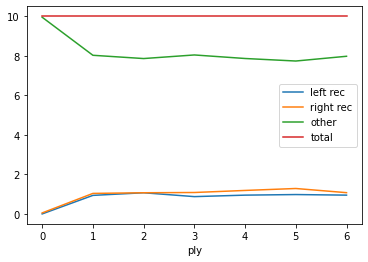

In [182]:
avg_per_position_left_depth_homepage.plot(legend=True)

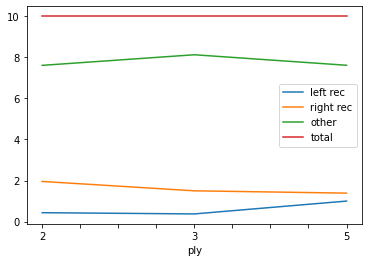

In [183]:
avg_per_position_right_depth_homepage.plot(legend=True)

# Survey

In [122]:
importer = JsonImporter()

survey_left_ids = []
survey_right_ids = []

for tree in survey_trees:
    id = (tree.split('_')[4]).replace('.txt', '')
    if 'Right' in tree:
        survey_right_ids.append(id)
    else:
        survey_left_ids.append(id)

survey_data = {
    'id': [],
    'position': [],
    'ply': [],
    'tree bias': [],
    'left rec': [],
    'right rec': [],
    'other': [],
    'total': [],
    'video bias': [],
    'video type': [],
    'sampled type': []
}

#create the csv for the trees
tree_number = 0
for tree in survey_trees:
    tree_number += 1
    print(f'{tree_number}/{len(survey_trees)}')
    id = (tree.split('_')[4]).replace('.txt', '')
    tree_bias = None
    if id in survey_left_ids:
        tree_bias = 'Left'
    elif id in survey_right_ids:
        tree_bias = 'Right'
    else:
        print(f'Problem')
    #'id', 'tree bias', 'left rec', 'right rec', 'other', 'total', 'video bias'
    with open(path_survey_trees + '\\' + tree, 'r') as outfile:
        data = outfile.read()
        root = importer.import_(data)
        position = 0
        for t in anytree.PreOrderIter(root):
            if t.id != 'dummy':
                survey_data['id'].append(id)
                survey_data['tree bias'].append(tree_bias)
                survey_data['position'].append(position)
                count = {
                    'left rec': 0,
                    'right rec': 0,
                    'other' : 0
                }
                # check that you only want top 5
                recommended_videos = t.top_10_recommended
                recommended_videos = [i for i in recommended_videos if not(i == None)]
                recommended_videos = recommended_videos[0:min(5, len(recommended_videos))]
                for rec in recommended_videos:
                    content_creator = url_to_content_creator(rec)
                    if content_creator != None:
                        bias = content_creator_to_bias(content_creator)
                    else:
                        bias = None
                    if (bias in count.keys()):
                        count[bias] += 1
                    else:
                        count['other'] += 1
                for k, v in count.items():
                    survey_data[k].append(v)

                survey_data['total'].append(5)
                video_bias = content_creator_to_bias(t.video['content creator'])
                survey_data['video bias'].append(video_bias)
                survey_data['video type'].append(t.actual_video_type)
                survey_data['sampled type'].append(t.sampled_type)

                ply = np.mod(position, 3)

                survey_data['ply'].append(ply)

                position += 1
print(len(urls_to_visit))

1/79
2/79
3/79
4/79
5/79
6/79
7/79
8/79
9/79
10/79


C:\Users\mikad\anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


11/79
12/79
13/79
14/79
15/79
16/79
17/79
18/79
19/79
20/79
21/79
22/79
23/79
24/79
25/79
26/79
27/79
28/79
29/79
30/79
31/79
32/79
33/79
34/79
35/79
36/79
37/79
38/79
39/79
40/79
41/79
42/79
43/79
44/79
45/79
46/79
47/79
48/79
49/79
50/79
51/79
52/79
53/79
54/79
55/79
56/79
57/79
58/79
59/79
60/79
61/79
62/79
63/79
64/79
65/79
66/79
67/79
68/79
69/79
70/79
71/79
72/79
73/79
74/79
75/79
76/79
77/79
78/79
79/79
0


In [123]:
for k, v in survey_data.items():
    print(k, len(v))

id 1896
position 1896
ply 1896
tree bias 1896
left rec 1896
right rec 1896
other 1896
total 1896
video bias 1896
video type 1896
sampled type 1896


In [124]:
survey_csv = pd.DataFrame.from_dict(survey_data)
survey_csv.head(20)

,id,position,ply,tree bias,left rec,right rec,other,total,video bias,video type,sampled type
0,0bd77d4c-a0f7-4b58-b048-06289937641a,0,0,Left,2,0,3,5,left rec,curated,curated
1,0bd77d4c-a0f7-4b58-b048-06289937641a,1,1,Left,0,0,0,5,left rec,curated,curated
2,0bd77d4c-a0f7-4b58-b048-06289937641a,2,2,Left,5,0,0,5,left rec,curated,curated
3,0bd77d4c-a0f7-4b58-b048-06289937641a,3,0,Left,1,0,1,5,left rec,curated,curated
4,0bd77d4c-a0f7-4b58-b048-06289937641a,4,1,Left,0,0,0,5,left rec,curated,curated
5,0bd77d4c-a0f7-4b58-b048-06289937641a,5,2,Left,0,0,0,5,left rec,curated,curated
6,0bd77d4c-a0f7-4b58-b048-06289937641a,6,0,Left,0,0,0,5,left rec,curated,curated
7,0bd77d4c-a0f7-4b58-b048-06289937641a,7,1,Left,0,0,0,5,left rec,curated,curated
8,0bd77d4c-a0f7-4b58-b048-06289937641a,8,2,Left,5,0,0,5,left rec,curated,curated
9,0bd77d4c-a0f7-4b58-b048-06289937641a,9,0,Left,4,0,1,5,left rec,curated,curated


In [125]:
right = survey_csv[depth_csv['tree bias'] == 'Right']
left = survey_csv[depth_csv['tree bias'] == 'Left']

avg_per_position_right = right.groupby('position').mean()
avg_per_position_left = left.groupby('position').mean()

<ipython-input-125-9032d794eeb3>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  right = survey_csv[depth_csv['tree bias'] == 'Right']
<ipython-input-125-9032d794eeb3>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  left = survey_csv[depth_csv['tree bias'] == 'Left']


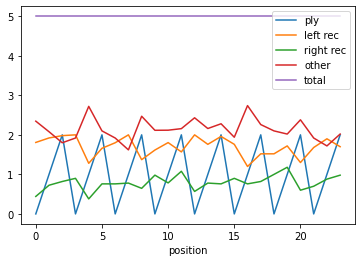

In [126]:
avg_per_position_left.plot(legend=True)

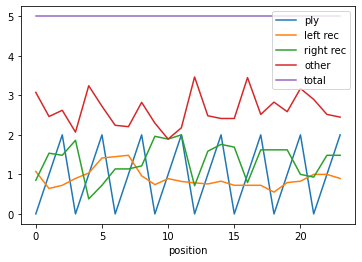

In [127]:
avg_per_position_right.plot(legend=True)

### ii. Homepage

In [ ]:
survey_homepage_data = {
    'id': [],
    'ply': [],
    'tree bias': [],
    'left rec' : [],
    'right rec': [],
    'other': [],
    'total' : []
}

homepage_number = 0
for homepage in survey_homepages:
    homepage_number += 1
    print(f'{homepage_number}/{len(survey_homepages)}')

    # check id
    id = (homepage.split('_')[4]).replace('.txt', '')

    # check ply
    ply = homepage.split('_')[1]
    tree_bias = None
    if id in survey_left_ids:
        tree_bias = 'Left'
    elif id in survey_right_ids:
        tree_bias = 'Right'
    else:
        print(f'Problem')

    with open(path_survey_homepage + '\\' + homepage, 'r') as outfile:
        # array of urls
        lines = outfile.read().splitlines()
        lines = [i for i in lines if (not(i == None) and not(i == ''))]
        lines = lines[0 : min(10, len(lines))]

        count = {
            'left rec': 0,
            'right rec': 0,
            'other': 0,
            'total': 0
        }
        none_count = 0
        for url in lines:
            content_creator = url_to_content_creator(url)
            if content_creator == None:
                none_count += 1
            else:
                bias = content_creator_to_bias(content_creator)
                count[bias] += 1
                count['total'] += 1
        for k, v in count.items():
            depth_homepage_data[k].append(v)
        survey_homepage_data['tree bias'].append(tree_bias)
        survey_homepage_data['ply'].append(ply)
        survey_homepage_data['id'].append(id)

    homepage_number += 1

1/539
Problem
3/539
Problem
5/539
Problem
7/539
Problem
9/539
Problem
11/539
Problem
13/539
Problem
15/539
Problem
17/539
Problem
19/539
Problem
21/539
Problem
23/539
Problem
25/539
Problem
27/539
Problem
29/539
Problem
31/539
Problem
33/539
Problem
35/539
Problem
37/539
Problem
39/539
Problem
41/539
Problem
43/539
Problem
45/539
Problem
47/539
Problem
49/539
Problem
51/539
Problem
53/539
Problem
55/539
Problem
57/539
Problem
59/539
Problem
61/539
Problem
63/539
Problem
65/539
Problem
67/539
Problem
69/539
Problem
71/539
Problem
73/539
Problem
75/539
Problem
77/539
Problem
79/539
Problem
81/539
Problem
83/539
Problem
85/539
Problem
87/539
Problem
89/539
Problem


In [ ]:
for k, v in depth_homepage_data.items():
    print(k, len(v))

In [ ]:
depth_homepage_csv = pd.DataFrame.from_dict(depth_homepage_data)
depth_homepage_csv.head(10)

In [ ]:
right_depth_homepage = depth_homepage_csv[depth_csv['tree bias'] == 'Right'][['ply', 'left rec', 'right rec', 'other', 'total']]
left_depth_homepage = depth_homepage_csv[depth_csv['tree bias'] == 'Left'][['ply', 'left rec', 'right rec', 'other', 'total']]

avg_per_position_right_depth_homepage = right_depth_homepage.groupby('ply').mean()
avg_per_position_left_depth_homepage = left_depth_homepage.groupby('ply').mean()

In [ ]:
avg_per_position_left_depth_homepage.plot(legend=True)

In [ ]:
avg_per_position_right_depth_homepage.plot(legend=True)

# Breadth

In [158]:

breadth_left_ids = []
breadth_right_ids = []

breadth_right_trees = []
breadth_left_trees = []

for trees in breadth_trees:
    id = (trees.split('_')[3]).replace('.txt', '')
    with open(path_breadth_trees + '\\' + trees, 'r') as outfile:
        data = outfile.read()
        root = importer.import_(data)
        if root.id in right_wing_seeds:
            breadth_right_ids.append(id)
        else:
            breadth_left_ids.append(id)

breadth_data = {
    'id': [],
    'ply': [],
    'left rec': [],
    'right rec': [],
    'other' : [],
    'total': [],
    'tree bias': [],
    'video bias': []
}

#create the csv for the trees
tree_number = 0
for tree in breadth_trees:
    tree_number += 1
    print(f'{tree_number}/{len(breadth_trees)}', end='')
    id = (tree.split('_')[3]).replace('.txt', '')
    tree_bias = None
    if id in breadth_left_ids:
        tree_bias = 'Left'
    elif id in breadth_right_ids:
        tree_bias = 'Right'
    else:
        print(f'Problem')

    print(f': {tree_bias} || ', end='')
    #'id', 'tree bias', 'left rec', 'right rec', 'other', 'total', 'video bias'
    with open(path_breadth_trees + '\\' + tree, 'r') as outfile:
        data = outfile.read()
        root = importer.import_(data)
        print(root.video['content creator'])
        for t in anytree.LevelOrderIter(root):
            if t.title != None:
                breadth_data['id'].append(id)
                breadth_data['tree bias'].append(tree_bias)

                count = {
                    'left rec': 0,
                    'right rec': 0,
                    'other' : 0
                }
                children = t.children
                if all(c.video != None for c in children) == True:
                    for child in children:
                        if child.video == None:
                            print('okay')
                        bias = content_creator_to_bias(child.video['content creator'])
                        if bias != None:
                            count[bias] += 1
                        else:
                            count['other'] += 1
                            print('bad')
                    breadth_data['total'].append(3)
                else:
                    breadth_data['total'].append(None)

                for k, v in count.items():
                    breadth_data[k].append(v)

                video_bias = content_creator_to_bias(t.video['content creator'])
                breadth_data['video bias'].append(video_bias)
                ply = t.depth

                breadth_data['ply'].append(ply)
print(len(urls_to_visit))

1/73: Right || Tim Pool
2/73: Left || Vox
3/73: Left || Destiny
4/73: Right || The Rubin Report
5/73: Right || StevenCrowder


C:\Users\mikad\anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


6/73: Left || Innuendo Studios
7/73: Left || Destiny
8/73: Left || Big Joel
9/73: Right || PragerU
10/73: Right || Blaire White
11/73: Left || hbomberguy
12/73: Left || Vaush
13/73: Left || The Majority Report w/ Sam Seder
14/73: Left || Vaush
15/73: Left || Vaush
16/73: Left || Shaun
17/73: Right || Tim Pool
18/73: Right || StevenCrowder
19/73: Right || Charlie Kirk
20/73: Right || The Rubin Report
21/73: Right || Michael Knowles
22/73: Right || Paul Joseph Watson
23/73: Right || Mark Dice
24/73: Right || Lauren Southern
25/73: Left || HasanAbi
26/73: Left || Vaush
27/73: Right || Sargon of Akkad
28/73: Right || Paul Joseph Watson
29/73: Left || The Majority Report w/ Sam Seder
30/73: Right || Michael Knowles
31/73: Left || Vaush
32/73: Left || hbomberguy
33/73: Left || Innuendo Studios
34/73: Left || Three Arrows
35/73: Right || The Daily Wire
36/73: Left || Big Joel
37/73: Right || Lauren Southern
38/73: Left || The Majority Report w/ Sam Seder
39/73: Left || Vaush
40/73: Left || Vo

In [159]:
for k, v in breadth_data.items():
    print(k, len(v))

id 8833
ply 8833
left rec 8833
right rec 8833
other 8833
total 8833
tree bias 8833
video bias 8833


In [161]:
breadth_csv = pd.DataFrame.from_dict(breadth_data)
breadth_csv.head(15)

,id,ply,left rec,right rec,other,total,tree bias,video bias
0,042d6afc-c005-42bc-ac93-8d8836f8e74e,0,0,1,2,3.0,Right,right rec
1,042d6afc-c005-42bc-ac93-8d8836f8e74e,1,0,3,0,3.0,Right,right rec
2,042d6afc-c005-42bc-ac93-8d8836f8e74e,1,0,0,3,3.0,Right,other
3,042d6afc-c005-42bc-ac93-8d8836f8e74e,1,0,0,3,3.0,Right,other
4,042d6afc-c005-42bc-ac93-8d8836f8e74e,2,0,2,1,3.0,Right,right rec
5,042d6afc-c005-42bc-ac93-8d8836f8e74e,2,0,3,0,3.0,Right,right rec
6,042d6afc-c005-42bc-ac93-8d8836f8e74e,2,0,3,0,3.0,Right,right rec
7,042d6afc-c005-42bc-ac93-8d8836f8e74e,2,0,0,3,3.0,Right,other
8,042d6afc-c005-42bc-ac93-8d8836f8e74e,2,0,0,3,3.0,Right,other
9,042d6afc-c005-42bc-ac93-8d8836f8e74e,2,0,0,3,3.0,Right,other


In [ ]:
# get an excel of the videos used as seed

In [163]:
right_breadth = breadth_csv[breadth_csv['tree bias'] == 'Right']
left_breadth = breadth_csv[breadth_csv['tree bias'] == 'Left']

avg_per_position_right_breadth = right_breadth.groupby('ply').mean()
avg_per_position_left_breadth = left_breadth.groupby('ply').mean()

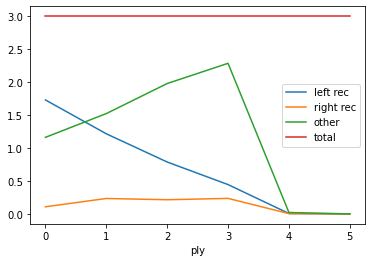

In [166]:
avg_per_position_left_breadth.plot(legend=True)

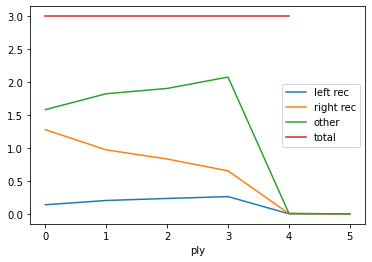

In [168]:
avg_per_position_right_breadth.plot(legend=True)

In [ ]:
shame = []
seeds = {
    'Title': [],
    'Content Creator': [],
    'URL': [],
    'Classification': []
}

for s in right_wing_seeds + left_wing_seeds:
    s = s.replace('\n', '')
    s = s.replace(' ', '')
    if s in video_info.keys():
        info = video_info[s]
        seeds['Title'].append(info['title'])
        seeds['Content Creator'].append(info['content creator'])
        seeds['URL'].append(s)

        if s in right_wing_seeds:
            seeds['Classification'].append('Right')
        else:
            seeds['Classification'].append('Left')
    else:
        shame.append(s)

print(len(shame))

In [34]:
seeds_csv = pd.DataFrame(seeds)
seeds_csv.to_csv('C:\\Users\\mikad\\PycharmProjects\\Comp_396_YouTube_Radicalization\\Analysis\\csvs\\' + 'seeds.csv')

In [15]:
for i in shame:
    print(i)

https://www.youtube.com/watch?v=XcV1AVNz8P8
https://www.youtube.com/watch?v=ij-C0lh5qQ4
https://www.youtube.com/watch?v=JNAnpkD8A7o
https://www.youtube.com/watch?v=OobZ0yArl2o
https://www.youtube.com/watch?v=aZtUTt7OPGI
https://www.youtube.com/watch?v=dWlYuvricgI&t=1s
https://www.youtube.com/watch?v=Tkr-azJVTAM
https://www.youtube.com/watch?v=4lGGlbZRoV4
https://www.youtube.com/watch?v=f9q0Xlnyl-A
https://www.youtube.com/watch?v=qa6txb6nYGI
https://www.youtube.com/watch?v=DWMQcKqSa28
https://www.youtube.com/watch?v=QsT7FaNowR4
https://www.youtube.com/watch?v=nORLTrzzNm8
https://www.youtube.com/watch?v=-tkGEFhHM5I
https://www.youtube.com/watch?v=8kntLVW3KRs
https://www.youtube.com/watch?v=jza2zLw_8cI
https://www.youtube.com/watch?v=_fEVHx-m_YA&t=228s
https://www.youtube.com/watch?v=8EwdsvbL43Y
https://www.youtube.com/watch?v=_GO2jneQJOo
https://www.youtube.com/watch?v=iNGf7XYtU2Q
https://www.youtube.com/watch?v=v6JW4OfLFbI
https://www.youtube.com/watch?v=NzefBA4NOLw
https://www.youtube.

In [16]:
x = 0
for k, v in video_info.items():
    if x > 20:
        break
    print(k, v)
    x += 1

https://www.youtube.com/watch?v=wM5NHC97JBw {'title': "World's First Automatic Strike Bowling Ball", 'content creator': 'Mark Rober', 'description': "You don't need to be good at bowling if you're good at engineering. \n\nGo sub to James' channel here:  https://www.youtube.com/user/jamesbruton", 'date': 'Nov 14, 2019', 'views': '44,111,594 views', 'comments': '18,261', 'likes': '720,268 likes', 'dislikes': ' Unavailable', 'video_length': 349.961, 'url': 'https://www.youtube.com/watch?v=wM5NHC97JBw', 'id': 'wM5NHC97JBw'}
https://www.youtube.com/watch?v=qeqhXvE5aPY {'title': 'Life without Water (Full Episode) | Wild Chile', 'content creator': 'Nat Geo WILD', 'description': 'At its Northern edge, in the Atacama desert, wildlife has spent millions of years adapting to a life without water.\n\nWatch more Destination Wild on Disney+: ', 'date': 'Jun 21, 2021', 'views': '1,027,912 views', 'comments': '363', 'likes': '11,058 likes', 'dislikes': ' Unavailable', 'video_length': 2663.981, 'url': 

# 3. Create CSV files

In [ ]:
breadth_csv.to_csv('C:\\Users\\mikad\\PycharmProjects\\Comp_396_YouTube_Radicalization\\Analysis\\csvs\\' + 'breadth_experiment.csv')
depth_csv.to_csv('C:\\Users\\mikad\\PycharmProjects\\Comp_396_YouTube_Radicalization\\Analysis\\csvs\\' + 'depth_experiment.csv')
survey_csv.to_csv('C:\\Users\\mikad\\PycharmProjects\\Comp_396_YouTube_Radicalization\\Analysis\\csvs\\' + 'survey_experiment.csv')
